# Auxiliary steps and makefile-style workflows

Auxiliary steps are special steps that are executed to provide [targets](../documentation/Targets_and_Actions.html) that are required by others.

For example, when the following step is executed with an input file `bamfile` (with extension `.bam`), it checks the existence of input file (`bamfile`), and a dependent index file (with extension `.bam.bai`).

```sos
[100 (call variant)]
input:   bamfile
depends: bamfile + '.bai'
run:
    # commands to call variants from 
    # input bam file
```

Because the step depends on an index file, SoS will look in the script for a step that provides such a target, which would be similar to

```sos
[index_bam : provides='{sample}.bam.bai']
input: f"{sample}.bam"
run: expand=True
     samtools index {input}
```

Such a step is characterized by a **`provides`** option (or a **`shared`** option that will be discussed later) and is called an auxiliary step. In this particular case, if `bamfile="AS123.bam"`, the requested dependent file would be `AS123.bam.bai`. Through the matching mechanism of option `provides`, the `index_bam` step would be executed with variables `sample="AS123"` and `output=["AS123.bam.bai"]`.

SoS will always check if an depdendent target can be generated by an auxiliary step. If a target cannot be generated by an auxiliary step, it must exist before the execution of the workflow. Otherwise, sos will add the auxiliary step to the DAG and execute the step to generate the file even if it already exists. The normal signature rules apply (see [Execution of workflow](../tutorials/Execution_of_Workflow.html) for details) so you use option `-s build` to ignore the auxiliary step if the target already exists.

An auxiliary step can trigger other auxiliary steps and form a DAG (Directed Acyclic Graph). Acutually, you can write workflows in a make-file style with all auxiliary steps and execute workflows defined by targets. If you are familiar with Makefile, especially [snakemake](https://bitbucket.org/johanneskoester/snakemake), it can be natural for you to implement your workflow in this style. The advantage of SoS is that **you can use either or both forward-style and makefile-style steps to define your workflow** and take advantages of both approaches. For example, people frequently need to create fake targets to trigger steps that do not produce any target in a makefile-style workflow system, but this is not needed in SoS because steps defined in forward-style will always be executed. 

## Step option `provides`

An auxiliary step can be defined by the `provides` option in section head, in the format of

```sos
[step_name : provides=target]
```

where `target` can be

* A filename or file pattern such as `"{sample}.bam.idx"`
* Other types of targets such as `executable("ms")`
* A list (sequence) of one or more file patterns and targets.

### File Pattern

A file pattern is a filename with optional patterns with variable names enbraced in `{ }`. SoS matches filenames with the patterns and, if successful, assign variables with matched parts of the names. For example,

```
[compress: provides = '{filename}.bam']
```
would be triggered with target `sample_A.bam` and `sample_B.bam`. When the step is triggered by `sample_A.bam`, it defines variable `filename` as `sample_A` and sets the output of the step as `sample_A.bam`.

The following example removes all local `*.bam` and `*.bam.bi` file before it executes three workflows defined by `targets`. We use magic `%run` to execute it, which is equivalent to executing it from command line using commands such as
```bash
    sos run myscript -t TS1.bam
```

In [1]:
%sandbox
%preview --off
%run -t TS1.bam

[compress: provides = '{filename}.bam']
print(f"> {step_name} input to {output}")
sh: expand=True
    touch {output}

[index: provides = '{filename}.bam.bai']
input: f"{filename}.bam"
print(f"> {step_name} {input} to {output}")
sh: expand=True
    touch {output}

INFO: Resolving ['TS1.bam'] objects from 0 nodes


> compress input to TS1.bam


In [2]:
%sandbox
%rerun -t TS2.bam.bai

INFO: Resolving ['TS2.bam.bai'] objects from 0 nodes
INFO: Resolving ['TS2.bam'] objects from 1 nodes


> compress input to TS2.bam
> index TS2.bam to TS2.bam.bai


As you can see from the output, when the first workflow is executed with target `TS1.bam`, step `compress` is executed to produce it. In the run, both steps are executed to generate `TS2.bam` and then `TS2.bam.bai`.

### Non-file targets

In addition to output files, an auxiliary step can provide targets of other types. A most widely used target is `sos_variable`, which provides variables that can be accessed by later steps. For example,

In [3]:
# remove var in case it is defined already
%dict --del numNotebooks

# this step provides variable `numNotebooks`
[count: provides=sos_variable('numNotebooks')]
import glob
numNotebooks = len(glob.glob('*.ipynb'))

[default]
depends: sos_variable('numNotebooks')
print(f"There are {numNotebooks} notebooks in this directory")

### Multiple targets

You can specify multiple targets to the `provides` option and a step would be triggered if any of the targets matches. For example, the `temp` step is triggered twice in the following example, first time by target `text.bak` and the second time by target `text.tmp`.

In [4]:
%sandbox
%preview --off

[temp: provides = ['{filename}.bak', '{filename}.tmp']]
print(f"Touch {output}")
sh: expand=True
    touch {output}

[default]
depends: 'text.bak', 'text.tmp'

### `output` statement

As you have noticed, auxiliary steps usually do not define their own `output` statement. This is because auxiliary steps have a default `output` statement

```
output:  __default_output__
```

where `__default_output__` is the matched target. You can cutomize the output of an auxiliary step by defining your own `output` statement. This technique is usually used for the generation of multiple output files.

For example, in the following example, step `touch` is triggered three times for the generation of three targets.

In [5]:
%sandbox
%preview --off

[touch: provides = ['1.txt', '2.txt', '3.txt']]
sh: expand=True
    echo "Create {output}"
    touch {output}

[default]
depends: '1.txt', '2.txt', '3.txt'

You can however design your auxiliary step to generate multiple outputs by specifying a different `output`:

In [6]:
%sandbox
%preview --off
%run

[touch: provides = ['1.txt', '2.txt', '3.txt']]
print(f"step triggered by {__default_output__}")
output: '1.txt', '2.txt', '3.txt'
sh: expand=True
    echo "Write A to {output}"
    touch {output}

[default]
depends: '1.txt', '2.txt', '3.txt'

INFO: Resolving ['1.txt', '2.txt', '3.txt'] objects from 1 nodes


step triggered by ['1.txt']
Write A to 1.txt 2.txt 3.txt


In this example, the `touch` step is triggered by one of the three files, but it produces three output files `1.txt`, `2.txt`, `3.txt`. The `default` step will not look for steps to generate the other two files because they have already been generated.

## Step option `shared`

Another common task of SoS steps is to provide some information through SoS variables. This can be achived by a `provides` option with `sos_variale` targets, but can be more easily implemented with a `shared` option.

In [7]:
# remove var in case it is defined already
%dict --del numNotebooks

# this step provides variable `numNotebooks`
[count: shared='numNotebooks']
import glob
numNotebooks = len(glob.glob('*.ipynb'))

[default]
depends: sos_variable('numNotebooks')
print(f"There are {numNotebooks} notebooks in this directory")

This workflow has one step that depends on a `sos_variable` `numNotebooks`. The `count` step is then executed to provide this variable.

There is however a minor difference between the `shared` and `provides` for the specification of shared variables. That is to say, whereas

```
[step: provides=[sos_variable('var1'), sos_variable('var2')]
```

would be triggered by `var1` or `var2` and generate **one of** the variables (due to the multi-target rule of option `provides`),

```
[step: shared=['var1', 'var2']]
```

would be assumed to generate **both of** the variables, so technically speaking the `shared` version is equivalent to

```
[step: provides=[sos_variable('var1'), sos_variable('var2')]
output: sos_variable('var1'), sos_variable('var2')
```

## Executing workflows with auxiliary steps

You can execute forward-style workflows by specifying workflow name (can be `default`) from command line. The workflow can trigger auxiliary steps for the generation of unavailable targets. The workflows are executed with a mind-setting of **apply workflow to certain input file**.

You can execute a makefile-style workflow by specifying one or more targets using option `-t` (target). SoS would collect all auxiliary steps in the script and create DAGs to generate these targets. The workflows are executed with a mind-setting of **execute necessary steps to generate specified output files**. Forward-style workflows defined in the script, if defined, would be ignored.

You can specify both a forward-style workflow and one or more targets using the `-t` option. In this case SoS would create a DAG with both the forward-style workflow and steps to produce the specified targets. The DAG would then be trimmed to a sub-DAG that produce only specified targets. The usage is usually used to **produce only selected targets from a forward-style workflow**. In contrast to the second case where targets have to be targets of auxiliary steps, targets specified in this case can be any output targets from the forward-style workflow.

Let us use a slightly complex example with both forward-style and auxiliary steps to demonstrate these three cases. In this case we are using action `sos_run` to execute workflows as multiple subworkflows, saving us the trouble to execute the script multiple times.

In [8]:
%sandbox --expect-error
%run

[gzip: provides='{name}.gz']
input: f"{name}"
print(f"> {step_name} {input} to {output}")
run: expand=True
    touch {output}

[download: provides='{name}.pdf']
print(f"> {step_name} {output}")
run: expand=True
    touch {output}

[process_10]
print(f"> Running step {step_name}")

[process_20]
depends: "step20.pdf"
output: "step20.out"
print(f"> Running step {step_name} to produce {output}")
run: expand=True
    touch {output}

[process_30]
output: "step30.out"
print(f"> Running step {step_name} to produce {output}")
run: expand=True
    touch {output}

[default]
print("Forward-style workflow")
sos_run("process")

print("\nMakefile-style workflow")
sos_run(targets="ms.pdf.gz")

print("\nTargets of forward-style workflow")
sos_run("process", targets="step20.out")

print("\nTargets from forward-style and makefile-style workflows")
sos_run("process", targets=["step20.out", "ms1.pdf.gz"])

os.remove('step20.out')
print("\nInvalid target step20.out")
sos_run(targets=["step20.out"])


Forward-style workflow


INFO: Resolving ['step20.pdf'] objects from 3 nodes


> Running step process_10
> download step20.pdf
touch step20.pdf

> Running step process_20 to produce step20.out
touch step20.out

> Running step process_30 to produce step30.out
touch step30.out


Makefile-style workflow


INFO: Resolving ['ms.pdf.gz'] objects from 0 nodes
INFO: Resolving ['ms.pdf'] objects from 1 nodes


> download ms.pdf
touch ms.pdf

> gzip ms.pdf to ms.pdf.gz
touch ms.pdf.gz


Targets of forward-style workflow
> Running step process_10


INFO: process_20 (index=0) is ignored due to saved signature



Targets from forward-style and makefile-style workflows


INFO: Resolving ['ms1.pdf.gz'] objects from 3 nodes
INFO: Resolving ['ms1.pdf'] objects from 4 nodes


> Running step process_10


INFO: process_20 (index=0) is ignored due to saved signature


> download ms1.pdf
touch ms1.pdf

> gzip ms1.pdf to ms1.pdf.gz
touch ms1.pdf.gz


Invalid target step20.out


INFO: Resolving ['step20.out'] objects from 0 nodes


This example has a forward-style workflow `process` in which step `process_20` depends on an auxiliary step `download`.

1. In the first case with command line equivalence

  ```bash
  sos run myscript process
  ```
  the forward-style workflow `process` is executed.

2. In the second example
  ```bash
  sos run myscript -t ms.pdf.gz
  ```
  two auxiliary steps `download` and `gzip` are called to produce target `ms.pdf.gz`.
  
3. In the third example
  ```bash
  sos run myscript process -t step20.out
  ```
  the `process` workflow is executed partially until it generates target `step20.out`.
  
4. In the fourth example
  ```bash
  sos run myscript process -t step20.out ms1.pdf.gz
  ```
  the `process` workflow is executed partially to produce target `step20.out`, and two auxiliary steps are executed to produce the additional target `ms1.pdf.gz`.
  
5. In the last example
  ```bash
  sos run myscript -t step20.out
  ```
  SoS could not find an auxiliary step to produce target `step20.out` and exited with error. Note that SoS would not try to execute a default workflow (workflow `default` or the only forwar-style workflow defined in the script) with the presence of option `-t`.

## Output DAG of execution

SoS allows the output of Direct Acyclic Graph in [graphviz dot format](http://www.graphviz.org/content/dot-language) of the execution of the workflow using option `-d`. DAGs would be written to standard output if the option `-d` is given without value, and to one or more files if a filename is given. An extension `.dot` would be automatically added if needed. Because of the dynamic nature of SoS, multiple DAGs could be outputted with increasing or decreasing number of nodes, resulting multiple files named `FILE.dot`, `FILE_2.dot`, etc.

Let us create an example with some nodes, and execute the workflow with two targets `B2.txt` and `C2.txt`

INFO: Resolving ['B1.txt', 'B2.txt', 'B2.txt', 'C2.txt'] objects from 2 nodes
INFO: Resolving ['B3.txt', 'C1.txt', 'C4.txt'] objects from 5 nodes
INFO: Resolving ['C3.txt'] objects from 8 nodes


%preview B2.txt

input: output: B2.txt

> B2.txt (0 B):

> dag.dot (340 B):

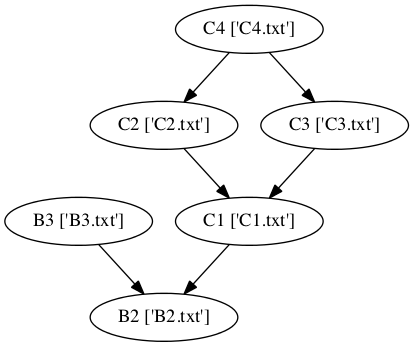

In [11]:
%sandbox --dir temp
%preview -n dag.dot

!rm -f A?.txt B?.txt C?.txt
%run  -t B2.txt C2.txt -d dag
[A_1]
input: 'B1.txt'
output: 'A1.txt'
sh:
    touch A1.txt

[A_2]
depends:  'B2.txt'
sh:
    touch A2.txt

[B1: provides='B1.txt']
depends: 'B2.txt'
sh:
    touch B1.txt

[B2: provides='B2.txt']
depends: 'B3.txt', 'C1.txt'
sh:
    touch B2.txt

[B3: provides='B3.txt']
sh:
    touch B3.txt

[C1: provides='C1.txt']
depends: 'C2.txt', 'C3.txt'
sh:
    touch C1.txt

[C2: provides='C2.txt']
depends: 'C4.txt'
sh:
    touch C2.txt

[C3: provides='C3.txt']
depends: 'C4.txt'
sh:
    touch C3.txt

[C4: provides='C4.txt']
sh:
    touch C4.txt


The `-d` option produced two `.dot` files that can be converted to png format using `dot` command (e.g. `dot dag.dot -T png > dag.png`) but here we use the `%preview` magic to display them directory.

As you might have guessed, the first DAG is the complete DAG created from the workflow, and the second DAG is the trimmed down DAG that produces targets `B2.txt` and `C2.txt`. In real world applications, the DAG might grow with additional auxiliary steps if some input or dependency files are unavailable.

In [10]:
# Clean up
!rm -rf temp